FSP Example:
Transcription of mRNA and translation of mRNA to protein.

In [1]:
#!pip install git+https://github.com/matteoacrossi/pyexpokit.git

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from fspCodes import solveFSP, buildFSP

In [3]:
# Step 1: The number of species is 3:  'mRNAnuc', 'mRNAcyt', 'Protein'
#         The initial condition is [0, 0, 0]
species = ['mRNAnuc', 'mRNAcyt', 'Protein']
x0 = np.array([0, 0, 0])

In [ ]:
# Step 2: Define the reaction stoichiometries
# The number of reactions is 6:
#         R1:   -> mRNAnuc
#         R2:  mRNAnuc ->
#         R3:  mRNAnuc -> mRNAcyt
#         R4:  mRNAcyt ->
#         R5:  mRNAcyt -> mRNAcyt + Protein
#         R6:  Protein ->

S = np.array([[ 1, -1,-1,  0,  0, 0],
              [ 0, 0,  1, -1,  0, 0],
              [ 0, 0,  0,  0,  1, -1]])

In [5]:
# Step 3: Define the reaction rate parameters as a dictionary
pars1 = {'kr':2,'kt':0.083, 'kp':0.5,'gr':0.05,'gp':0.25}
pars2 = {'kr':2,'kt':0.0083,'kp':0.5,'gr':0.05,'gp':0.25}
def W(x,t,pars):
    return np.array([pars['kr']+0*x[0],  # Note that 0*x[0] is used to broadcast the scalar to an array
                    pars['gr']*x[0],
                    pars['kt']*x[0],
                    pars['gr']*x[1],
                    pars['kp']*x[1],
                    pars['gp']*x[2]])

In [6]:
# Step 4: Define the states in the FSP approximation
# Specify the State Space of the FSP projection.
maxSpecies = np.array([[60], [60], [100]])
states = np.zeros((3, np.prod(maxSpecies[:,0]+1)), dtype=int)

vec = np.ones(len(maxSpecies), dtype=int)  # Vector to transform the state to the index
for i in range(len(maxSpecies)):
    vec[i] = np.prod(maxSpecies[i+1:,0]+1)  # The number of states for the next species

for i in range(maxSpecies[0,0]+1):
    for j in range(maxSpecies[1,0]+1):
        for k in range(maxSpecies[2,0]+1):
            state = np.array([i,j,k])
            index = np.dot(state, vec)
            states[:,index] = state

In [7]:
# Step 5: Build the infinitesimal generator matrix
infGenTotal1 = buildFSP(S, W, states, pars1, maxSpecies)
infGenTotal2 = buildFSP(S, W, states, pars2, maxSpecies)

In [8]:
# Step 6: Specify Initial condition (all zeros with probability one)
y0 = np.zeros((states.shape[1]+1,))
y0[0] = 1

In [9]:
# Step 7: Solve the FSP
t_eval1 = np.linspace(0, 120, 25)
solution1 = solveFSP(infGenTotal1, y0, t_eval1)
t_eval2 = np.linspace(120, 200, 17)
solution2 = solveFSP(infGenTotal2, solution1[-1,:].T, t_eval2)

In [10]:
# Concatenate the two solutions, removing the duplicate last row of the first solution
t_eval = np.concatenate((t_eval1[:-1], t_eval2), axis=0)
solution = np.concatenate((solution1[:-1], solution2), axis=0)

Text(0, 0.5, 'FSP Error')

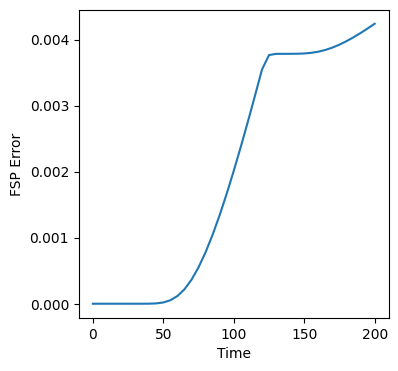

In [11]:
# Plot the results
# Plot the error of the FSP vs time
plt.figure(figsize=(4,4))
plt.plot(t_eval, solution[:,-1])
plt.xlabel('Time')
plt.ylabel('FSP Error')

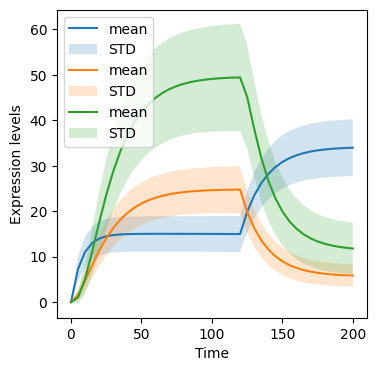

In [12]:
# Plot the mean and standard deviation of the FSP vs time
plt.figure(figsize=(4,4))
for i in range(states.shape[0]):
    mean = states[i,:].dot(solution[:,:-1].T)
    mean2 = (states[i,:]**2).dot(solution[:,:-1].T)
    var = mean2 - mean**2
    plt.plot(t_eval, mean, label='mean')
    plt.fill_between(t_eval, mean - np.sqrt(var), mean + np.sqrt(var), alpha=0.2, label='STD')
plt.xlabel('Time')
plt.ylabel('Expression levels')
plt.legend()
plt.show()

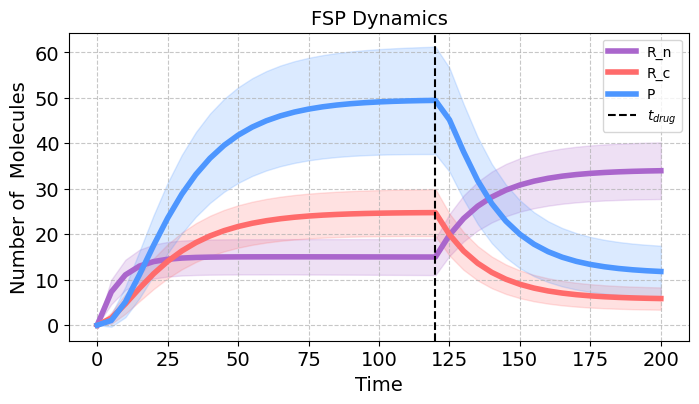

In [30]:
#@title Plotting configuration

mpl.rcParams.update({
    'font.family': 'DejaVu Sans'
})

plt.rcParams.update({
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 10,
    'font.family': 'DejaVu Sans'
})





def plotting_fsp(t_eval, states, solution, state_labels=None, state_colors=None, drug_application_time = None,
                 figsize=(4, 4), xlabel='Time', ylabel='Expression levels', title='FSP Dynamics',
                 save_figure=True, plot_name='fsp.jpg', folder_outputs=None):
    """
    Plots the mean and standard deviation of the FSP over time for each state.
    
    Parameters:
        t_eval (array-like): Time evaluation points.
        states (np.array): 2D array of state information, shape (num_states, state_values).
        solution (np.array): 2D array with the solution data; the last column is excluded for dot products.
        state_labels (dict, optional): Mapping of state indices to custom labels.
        state_colors (dict, optional): Mapping of state indices to colors.
        figsize (tuple, optional): Size of the figure.
        xlabel (str, optional): Label for the x-axis.
        ylabel (str, optional): Label for the y-axis.
        title (str, optional): Title of the plot.
        save_figure (bool, optional): Whether to save the figure.
        plot_name (str, optional): File name for the saved figure.
        drug_application_time (float, optional): Time at which the drug is applied.
        folder_outputs (Path or None, optional): Directory path to save the figure.
    """

    def plot_state_trajectories(t_eval, state_index, states, solution, label_mean, color):
        # Compute the mean and standard deviation for the state using a dot product
        mean = states[state_index, :].dot(solution[:, :-1].T)
        mean2 = (states[state_index, :] ** 2).dot(solution[:, :-1].T)
        var = mean2 - mean ** 2
        std = np.sqrt(var)
        # Plot the mean trajectory with a solid line and standard deviation as a shaded area
        plt.plot(t_eval, mean, '-', lw=4, label=label_mean, color=color)
        plt.fill_between(t_eval, mean - std, mean + std, alpha=0.2, color=color)

    plt.figure(figsize=figsize)
    num_states = states.shape[0]
    for i in range(num_states):
        # Use custom label if provided; otherwise, default to 'State i mean'
        label_mean = state_labels[i] if state_labels is not None and i in state_labels else f'State {i} mean'
        # Use custom color if provided; otherwise, let matplotlib assign a color automatically
        color = state_colors[i] if state_colors is not None and i in state_colors else None
        plot_state_trajectories(t_eval, i, states, solution, label_mean, color)

    if drug_application_time is not None:
        plt.axvline(x=drug_application_time, color='k', linestyle='--', label= r'$t_{drug}$',lw=1.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)

    if save_figure:
        if folder_outputs is None:
            plt.savefig(plot_name, dpi=300, bbox_inches='tight', transparent=True, pad_inches=0.1)
        else:
            plt.savefig(folder_outputs.joinpath(plot_name), dpi=300, bbox_inches='tight', transparent=False, pad_inches=0.1)
    plt.show()

# Define custom labels and colors for the states
state_labels = {0: 'R_n', 1: 'R_c', 2: 'P'}


# Assign colors to each species for plotting
colors = [ '#FBD148', '#6BCB77', '#AA66CC','#FF6B6B', '#4D96FF']
#colors = [ '#FBD148', '#6BCB77', '#AA66CC','#FF6B6B', '#4D96FF']

state_colors = {
    0: colors[2],
    1: colors[3],
    2:  colors[4]
}


# Plot the FSP dynamics
plotting_fsp(t_eval, states, solution, state_labels=state_labels, state_colors=state_colors,drug_application_time = 120,
             figsize=(8, 4), xlabel='Time', ylabel='Number of  Molecules', title='FSP Dynamics',
             save_figure=True)


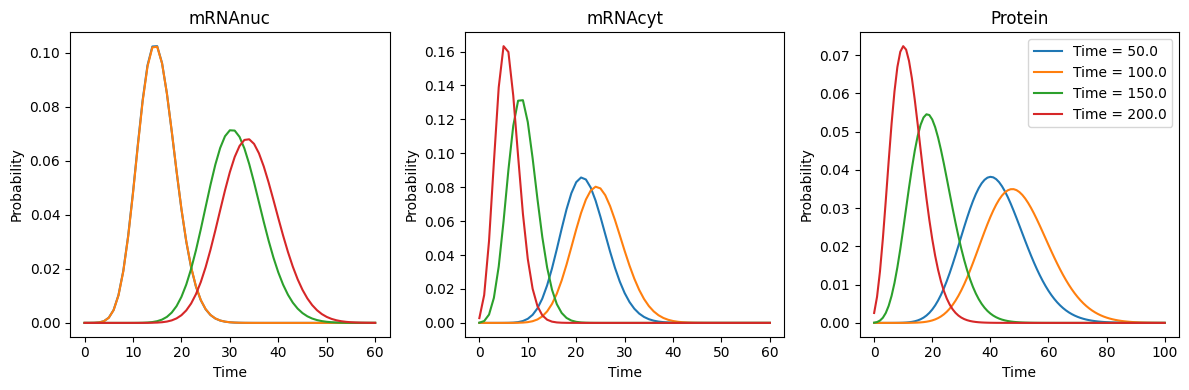

In [13]:
# Plot the probabilities of the states at given time points
iTime = [10, 20, 30, 40]

fig, ax = plt.subplots(1, 3, figsize=(12,4))
for Time in iTime:
    for i in range(states.shape[0]):
        C = np.zeros((maxSpecies[i,0]+1, solution.shape[1]-1))
        for j in range(solution.shape[1]-1):
            C[states[i,j],j] = 1
        P = C@solution[Time,:-1].T
        x = np.arange(maxSpecies[i,0]+1)
        ax[i].plot(x, P, label='Time = '+str(t_eval[Time]))
        ax[i].set_title(species[i])
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel('Probability')
plt.tight_layout()
plt.legend()
plt.show()

/var/folders/v9/d_0z5c956bg0n0s33zzf81s40000gp/T/ipykernel_39225/3389945531.py:14: UserWarning: The following kwargs were not used by contour: 'offset'
  ax[0].contourf(x, y, np.sum(tensor[:,:,:,iTime], axis=2), offset=0, alpha=0.75)
/var/folders/v9/d_0z5c956bg0n0s33zzf81s40000gp/T/ipykernel_39225/3389945531.py:15: UserWarning: The following kwargs were not used by contour: 'offset'
  ax[1].contourf(z, y, np.sum(tensor[:,:,:,iTime], axis=0), offset=0, alpha=0.75)
/var/folders/v9/d_0z5c956bg0n0s33zzf81s40000gp/T/ipykernel_39225/3389945531.py:16: UserWarning: The following kwargs were not used by contour: 'offset'
  ax[2].contourf(z, x, np.sum(tensor[:,:,:,iTime], axis=1), offset=0, alpha=0.75)


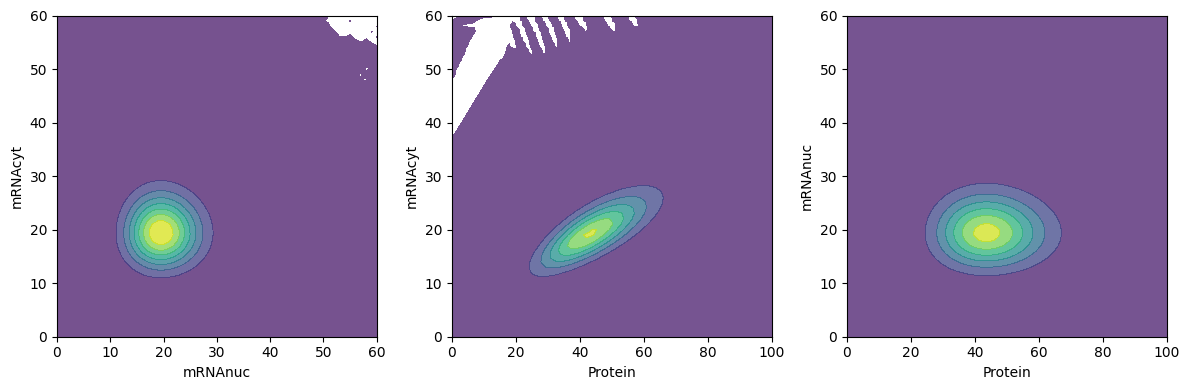

In [14]:
# Construct the solution tensor
iTime = 25

tensor = np.zeros((maxSpecies[0,0]+1, maxSpecies[1,0]+1, maxSpecies[2,0]+1, len(t_eval)))
for i in range(states.shape[1]):
    tensor[states[0,i], states[1,i], states[2,i], :] = solution[:,i]

# Plot the solution tensor
fig, ax = plt.subplots(1, 3, figsize=(12,4))
x = np.arange(maxSpecies[0,0]+1)
y = np.arange(maxSpecies[1,0]+1)
z = np.arange(maxSpecies[2,0]+1)

ax[0].contourf(x, y, np.sum(tensor[:,:,:,iTime], axis=2), offset=0, alpha=0.75)
ax[1].contourf(z, y, np.sum(tensor[:,:,:,iTime], axis=0), offset=0, alpha=0.75)
ax[2].contourf(z, x, np.sum(tensor[:,:,:,iTime], axis=1), offset=0, alpha=0.75)
ax[0].set_xlabel('mRNAnuc')
ax[0].set_ylabel('mRNAcyt')
ax[1].set_xlabel('Protein')
ax[1].set_ylabel('mRNAcyt')
ax[2].set_xlabel('Protein')
ax[2].set_ylabel('mRNAnuc')
plt.tight_layout()
plt.show()